# Evaluation of the MADDPG Stock Market

In [1]:
from __future__ import annotations

import os
from typing import Dict

import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
from matplotlib import pyplot as plt

from src.ddpg import DDPGAgent
from src.env import LogarithmAndIntActionWrapper, StockMarketEnv
from src.types import OptInt, PathLike
from src.utils import get_agent_dims, process_step_ac

plt.style.use('seaborn-paper')
sns.set_style('whitegrid')

In [2]:
# Environment Arguments
num_agents: int = 10
max_cycles: int = 390
num_company: int = 5

# Network Arguments
exp_name: str = 'stock_market_10_bs_256_lr_0.01'
epoch: int = 200
ckpt_dir: PathLike = os.path.join(
    f'../../run_logs/04-12-2022_08-12-01_{exp_name:s}',
    'checkpoint',
    f'{exp_name:s}_{epoch:d}.pt'
)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Modify accordingly
batch_size: int = 64
device = th.device('cuda')
max_episode_steps: OptInt = None

In [3]:
# Make Stock Market Environment
env = LogarithmAndIntActionWrapper(StockMarketEnv(
    num_agents=num_agents,
    max_cycles=max_cycles,
    num_company=num_company
))
obs_n = env.reset()
print('Agents: ', list(obs_n.keys()))

Agents:  ['agent_0', 'agent_1', 'agent_2', 'agent_3', 'agent_4', 'agent_5', 'agent_6', 'agent_7', 'agent_8', 'agent_9']


In [4]:
# Load checkpoints
agents: Dict[str, DDPGAgent] = {}

# Initialize environment information
agent_dim = get_agent_dims(env)
if hasattr(env, 'state_space'):
    ob_n_dim = env.state_space.shape[0]
else:
    ob_n_dim = sum(val[0] for val in agent_dim.values())
ac_n_dim = sum(val[1] for val in agent_dim.values())

state_dict = th.load(ckpt_dir)
for agent_id, (ob_dim, ac_dim) in agent_dim.items():
    agent = DDPGAgent(critic_observation_size=ob_n_dim,
                     policy_observation_size=ob_dim,
                     critic_action_size=ac_n_dim,
                     policy_action_size=ac_dim,
                     device=device,
                     learning_rate=1e-4)
    agent.load_state_dict(state_dict[agent_id])
    agents[agent_id] = agent

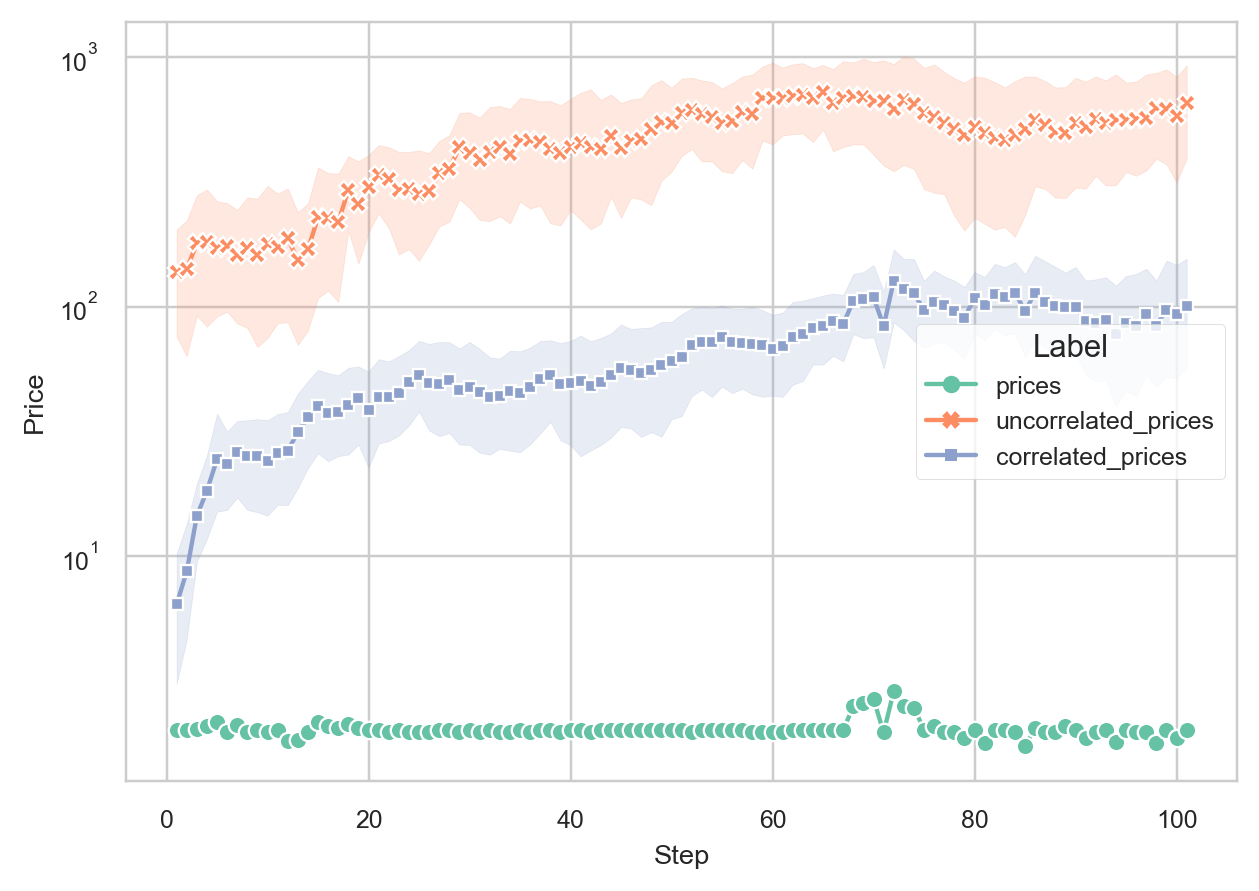

In [6]:
# Evaluation for one episode
episode_data = pd.DataFrame(columns=['Step', 'Price', 'Label'])

ob_n = env.reset()
state = env.state()
episode_done = False
step: int = 1 
while env.agents and not episode_done:
    actions = {}
    for agent_id, ob in ob_n.items():
        ob = th.from_numpy(ob).view(1, -1).float().to(device)
        ac = agents[agent_id].get_action(ob, explore=False)
        actions[agent_id] = process_step_ac(ac, env.action_space(agent_id))
    
    ob_n, _, _, truncated_n, info = env.step(actions)
    episode_done = all(truncated_n.values())

    # Process and store data
    for key, value in info.items():
        if isinstance(value, float):
            episode_data.loc[len(episode_data)] = [step, value, key]
        if isinstance(value, np.ndarray):
            episode_data = pd.concat([
                episode_data,
                pd.DataFrame.from_dict({
                    'Step': [step] * len(value),
                    'Price': value,
                    'Label': [key] * len(value)
                })
            ])

    step += 1

# Plotting
fig, ax = plt.subplots(1, 1, dpi=224)
ax = sns.lineplot(
    data=episode_data,
    x='Step', y='Price', hue='Label', palette='Set2',
    style='Label', markers=True, dashes=False, ax=ax
)
ax.set_yscale('log')